In [2]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
density_data = pd.read_csv("../Curated_data/cluster_0_data.csv", low_memory=False)


In [4]:
mineral = 'Density_gcm3'
filter = ['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']
deposit_data = density_data

deposit_data = deposit_data.dropna(subset=[mineral] + filter)
df1 = deposit_data
variable=mineral

In [5]:
two_composite_1covariates = deposit_data

# Calculate the percentage of missing values for each variable
missing_percentage = (two_composite_1covariates.isnull().sum() / len(two_composite_1covariates)) * 100

# Identify variables with more than 15% missing values
variables_to_remove = missing_percentage[missing_percentage > 5].index

# Drop the identified variables from the DataFrame
two_composite_1covariates = two_composite_1covariates.drop(columns=variables_to_remove)


encoded_data = two_composite_1covariates.copy()

threshold = 10

for column in two_composite_1covariates.columns:
    if two_composite_1covariates[column].dtype == 'object':
        unique_values = two_composite_1covariates[column].nunique()
        
        # Check if the number of unique values is within the threshold
        if unique_values <= threshold:
            # Perform one-hot encoding for columns with unique values within the threshold
            encoded_columns = pd.get_dummies(encoded_data[column], prefix=column)
            encoded_columns = encoded_columns.astype(int)  # Convert to integers (0 or 1)
            encoded_data = pd.concat([encoded_data, encoded_columns], axis=1)
            encoded_data = encoded_data.drop(columns=[column])




# Identify the encoded columns based on the common pattern
encoded_columns = [col for col in encoded_data.columns if '_Code_' in col]

# List to store the total columns
total_columns = []

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column and sum them
    encoded_data[total_column] = (
        encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    )

# List to store the total columns
total_columns = []

# Initialize a dictionary to accumulate totals for each category
category_totals = {}

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    if total_column not in total_columns:
        total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column
    total_values = encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    
    # Accumulate the totals for each category
    if total_column in category_totals:
        category_totals[total_column] += total_values
    else:
        category_totals[total_column] = total_values

# Add accumulated totals to the DataFrame
for total_column, total_values in category_totals.items():
    encoded_data[total_column] = total_values


In [6]:
variable_names = ['Sc_ppm',
 'Al_pct',
 'Y_ppm',
 'V_ppm',
 'Sr_ppm',
 'Ca_pct',
 'P_ppm',
 'Si_pct',
 'Li_ppm',
 'Mg_pct',
 'La_ppm',
 'RQD_Pct',
 'Alt1_Int_wk',
 'Ba_ppm',
 'Sulph1_Code_PO',
 'IP_pct',
 'Sulph2_Code_CP',
 'Sulph2_Code_PO',
 'X',
 'PY_Total',
 'Z',
 'PO_Total',
 'CP_Total',
 'Cr_ppm',
 'B_ppm',
 'Y',
 'Sb_ppm',
 'Weathering']

In [7]:
filtered_encoded_data = encoded_data[encoded_data.columns.intersection(variable_names+ ['Density_gcm3', 'Name'])]

deposit_data = encoded_data[['Name', 'X', 'Y', 'Z', 'Density_gcm3', 'RQD_Pct', 'Cr_ppm', 'CP_Total',
       'PO_Total', 'PY_Total']]
total_columns = ['CP_Total','PO_Total', 'PY_Total']

#all covariates
#covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm']
#sulphides only
#covariates = total_columns[:3] 
#No covariates, only spatial
covariates = []

deposit_data.describe()
deposit_data.fillna(0, inplace=True)
deposit_data

C:\Users\23478671\AppData\Local\Temp\ipykernel_6696\443229254.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total
393,KV-NME001,3498922.13,7511747.51,148.80,3.13,88.00,212.6,1.0,1.0,0.0
394,KV-NME001,3498922.68,7511747.45,146.88,3.15,88.00,268.0,1.0,1.0,0.0
434,KV-NME001,3498945.16,7511745.25,70.14,3.22,99.00,215.0,1.0,1.0,0.0
435,KV-NME001,3498945.73,7511745.20,68.22,3.22,99.00,236.0,1.5,2.0,0.0
436,KV-NME001,3498946.29,7511745.15,66.30,3.22,99.00,256.0,2.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
81071,KV365,3499347.52,7510618.17,85.03,3.44,92.35,131.0,0.2,3.0,0.0
81072,KV365,3499347.32,7510617.19,83.30,3.43,92.35,125.0,0.2,3.0,0.0
81073,KV365,3499347.13,7510616.22,81.56,3.44,85.84,128.0,0.2,3.0,0.0
81074,KV365,3499346.93,7510615.24,79.83,3.40,85.84,129.0,0.2,3.0,0.0


In [8]:
deposit_data

,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total
393,KV-NME001,3498922.13,7511747.51,148.80,3.13,88.00,212.6,1.0,1.0,0.0
394,KV-NME001,3498922.68,7511747.45,146.88,3.15,88.00,268.0,1.0,1.0,0.0
434,KV-NME001,3498945.16,7511745.25,70.14,3.22,99.00,215.0,1.0,1.0,0.0
435,KV-NME001,3498945.73,7511745.20,68.22,3.22,99.00,236.0,1.5,2.0,0.0
436,KV-NME001,3498946.29,7511745.15,66.30,3.22,99.00,256.0,2.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
81071,KV365,3499347.52,7510618.17,85.03,3.44,92.35,131.0,0.2,3.0,0.0
81072,KV365,3499347.32,7510617.19,83.30,3.43,92.35,125.0,0.2,3.0,0.0
81073,KV365,3499347.13,7510616.22,81.56,3.44,85.84,128.0,0.2,3.0,0.0
81074,KV365,3499346.93,7510615.24,79.83,3.40,85.84,129.0,0.2,3.0,0.0


In [9]:
# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']   # Add all columns you want to normalize

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)

scaler = MinMaxScaler()
deposit_data.loc[:, [mineral] +covariates] = scaler.fit_transform(deposit_data.loc[:,[mineral] + covariates])


C:\Users\23478671\AppData\Local\Temp\ipykernel_6696\1488387108.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_6696\1488387108.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_6696\1488387108.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [10]:
# lon = df1.values[:,4]
# lat = df1.values[:,5]
# az = df1.values[:,6]

# normalized_lon = (lon-min(lon))/(max(lon)-min(lon))
# normalized_lat = (lat-min(lat))/(max(lat)-min(lat))
# normalized_az = (az-min(az))/(max(az)-min(az))
# N = lon.shape[0]

In [11]:

lon = df1.values[:, 4]
lat = df1.values[:, 5]
az = df1.values[:, 6]

# Subtract the minimum values for each array
lon = lon - np.min(lon)
lat = lat - np.min(lat)
az = az - np.min(az)

# Calculate the overall minimum and maximum values from the entire dataset
min_value = np.min([np.min(lon), np.min(lat), np.min(az)])
max_value = np.max([np.max(lon), np.max(lat), np.max(az)])

# Scale the arrays to (0, 1) using the calculated minimum and maximum values
normalized_lon = (lon - min_value) / (max_value - min_value)
normalized_lat = (lat - min_value) / (max_value - min_value)
normalized_az = (az - min_value) / (max_value - min_value)

N = lon.shape[0]

# Display the normalized arrays
print("Normalized Lon:", normalized_lon)
print("Normalized Lat:", normalized_lat)
print("Normalized Az:", normalized_az)


Normalized Lon: [0.43781378776682156 0.43806121898106964 0.4481744075146454 ...
 0.6290106350432114 0.6289206600563835 0.6288351838188028]
Normalized Lat: [0.5098162710765618 0.5097892785806601 0.5087995537240868 ...
 0.0008772561228813492 0.0004363786870266015 0.0]
Normalized Az: [0.46145471558890383 0.4605909557141493 0.42606755322005485 ...
 0.4312051249751051 0.43042684133795656 0.4296440589514603]


In [12]:
num_basis = [10**3,19**3,37**3]
knots_1dx = [np.linspace(0,1,int(i**(1/3))+1) for i in num_basis]
knots_1dy = [np.linspace(0,1,int(i**(1/3))+1) for i in num_basis]
knots_1dz = [np.linspace(0,1,int(i**(1/3))+1) for i in num_basis]


##Wendland kernel
basis_size = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/(num_basis[res]**(1/3))*2.5
    knots_x, knots_y, knots_z = np.meshgrid(knots_1dx[res],knots_1dy[res], knots_1dz[res])
    knots = np.column_stack((knots_x.flatten(),knots_y.flatten(),knots_z.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(np.vstack((normalized_lon,normalized_lat, normalized_az)).astype(float).T-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + basis_size] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + basis_size] = 0
    basis_size = basis_size + num_basis[res]

In [13]:
## Romove the all-zero columns
idx_zero = np.array([], dtype=int)
for i in range(phi.shape[1]):
    if sum(phi[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

phi_reduce = np.delete(phi,idx_zero,1)
print(phi.shape)
print(phi_reduce.shape)

(2618, 58512)
(2618, 6403)


In [14]:

len_phi = np.shape(phi_reduce)[1]

# Create a DataFrame
df = pd.DataFrame(phi_reduce, columns=[f'phi_{i}' for i in range(len_phi)])

# Display the DataFrame
print(df)


      phi_0  phi_1  phi_2  phi_3  phi_4  phi_5  phi_6     phi_7     phi_8  \
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  0.000000   
1       0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  0.000000   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  0.000000   
3       0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  0.000000   
4       0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000  0.000000   
...     ...    ...    ...    ...    ...    ...    ...       ...       ...   
2613    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000246  0.003618   
2614    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000262  0.003631   
2615    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000279  0.003641   
2616    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000297  0.003651   
2617    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000315  0.003659   

         phi_9  ...  phi_6393  phi_6394  phi_6395  phi_6396  phi_6397  \
0 

In [15]:
df_reset = df.reset_index(drop=True)
deposit_data_reset = deposit_data.reset_index(drop=True)

# Concatenate along columns
deposit_data = pd.concat([deposit_data_reset, df], axis=1)

# Display the resulting DataFrame
deposit_data

,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total,...,phi_6393,phi_6394,phi_6395,phi_6396,phi_6397,phi_6398,phi_6399,phi_6400,phi_6401,phi_6402
0,KV-NME001,0.437814,0.509816,0.461455,0.400922,88.00,212.6,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KV-NME001,0.438061,0.509789,0.460591,0.410138,88.00,268.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KV-NME001,0.448174,0.508800,0.426068,0.442396,99.00,215.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KV-NME001,0.448431,0.508777,0.425204,0.442396,99.00,236.0,1.5,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KV-NME001,0.448683,0.508755,0.424340,0.442396,99.00,256.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,KV365,0.629186,0.001755,0.432766,0.543779,92.35,131.0,0.2,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2614,KV365,0.629096,0.001314,0.431988,0.539171,92.35,125.0,0.2,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2615,KV365,0.629011,0.000877,0.431205,0.543779,85.84,128.0,0.2,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2616,KV365,0.628921,0.000436,0.430427,0.525346,85.84,129.0,0.2,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Assuming deposit_data is your DataFrame
# Extract the names of the first 98 columns
phi_columns = deposit_data.columns[10:].tolist()

# Display the list of column names
print(phi_columns[:10])


['phi_0', 'phi_1', 'phi_2', 'phi_3', 'phi_4', 'phi_5', 'phi_6', 'phi_7', 'phi_8', 'phi_9']


In [17]:
deposit_data = deposit_data.dropna(subset=['Density_gcm3'] + covariates + phi_columns)

C:\Users\23478671\AppData\Local\Temp\ipykernel_6696\146396046.py:27: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_6696\146396046.py:28: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_6696\146396046.py:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_6696\146396046.py:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta

- Iteration 0, MSE: 0.5442
- Iteration 100, MSE: 0.0108
- Iteration 200, MSE: 0.0058
- Iteration 300, MSE: 0.0041
- Iteration 400, MSE: 0.0037
- Iteration 500, MSE: 0.0031
- Iteration 600, MSE: 0.0027


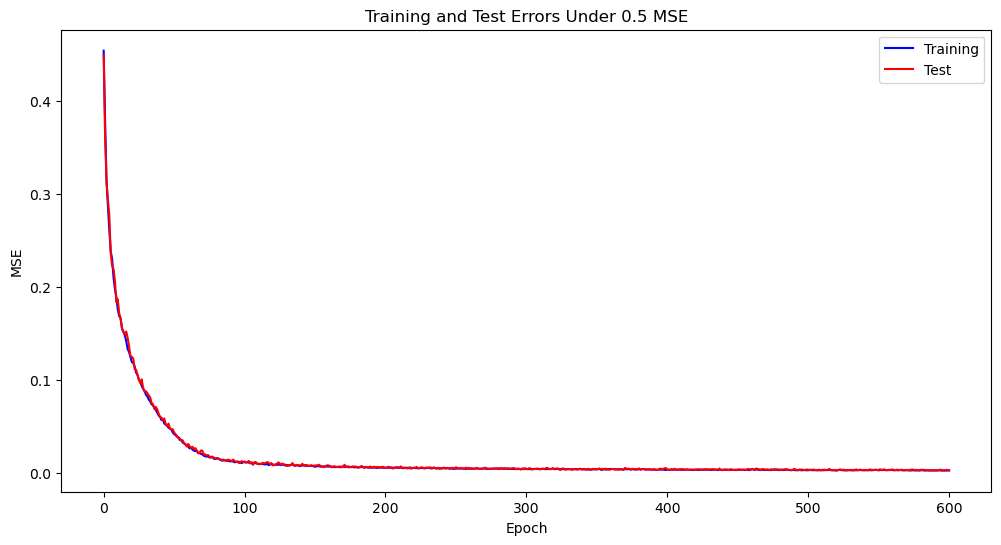

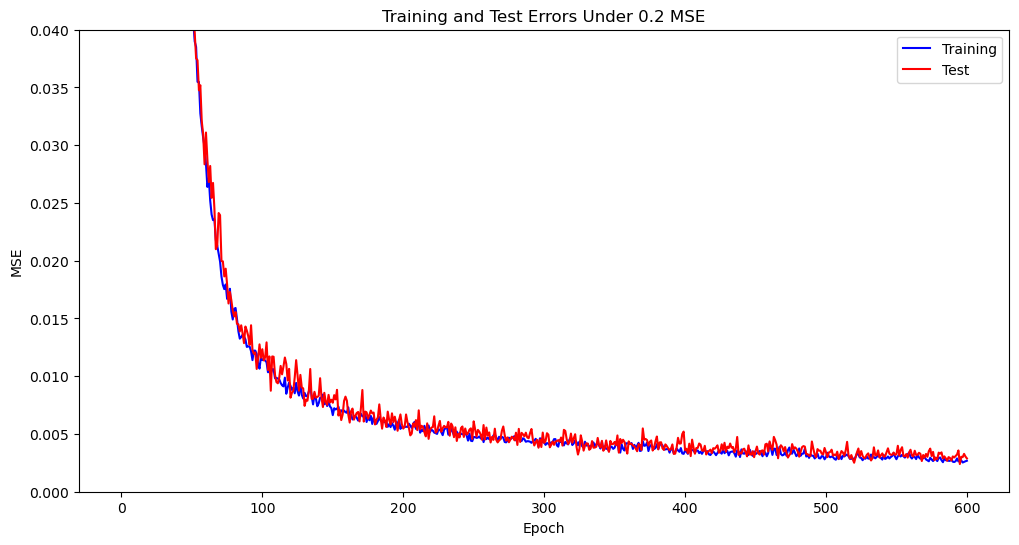

In [18]:
p = len(phi_columns) + len(covariates)

x = deposit_data[phi_columns + covariates].values #[:,np.newaxis] makes the second dimension explicit
y = deposit_data[[variable]].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(deposit_data),p)
x = x[:,[i for i in range(p)]]

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)


# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# model = nn.Sequential(
#     nn.Linear(in_features=p, out_features=1000),
#     nn.ReLU(),
#     nn.Linear(in_features=1000, out_features=1)
# )

model = nn.Sequential(
    nn.Linear(in_features=p, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5) ,
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=1))


mse_loss = nn.MSELoss()
#Apparently lr=0.005 is better than 0.01 and than 0.001: quicker and better convergence
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(601):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 100 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.4f}')




# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.5 MSE')
plt.show()



# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.04)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()








## BEST DEEPKRIGING NORMAL

In [19]:
# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

# Assuming deposit_data, covariates, and other necessary variables are defined

# Create an array to store metrics for each fold
test_mse_list = []
test_rmse_list = []
test_mae_list = []
test_r2_list = []



# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train = train_data[phi_columns + covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test = test_data[phi_columns + covariates].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network
    model = nn.Sequential(
        nn.Linear(in_features=p, out_features=100),
        nn.ReLU(),
        nn.Dropout(0.5) ,
        nn.BatchNorm1d(100),
        nn.Linear(in_features=100, out_features=100),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=100, out_features=100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
        nn.Linear(in_features=100, out_features=1))


    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(601):
        pre = model(torch.tensor(x_train, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # # Use ACD for interpretations
    # from acd import AttributionPriorExplainer
    # explainer = AttributionPriorExplainer(model, method='cd')
    # feature_attributions = explainer.attributions(torch.tensor(x_test, dtype=torch.float32))

    # # Print or analyze interpretations as needed
    # print(f"\nFeature Attributions for Fold {fold + 1}:")
    # print("Feature Attributions:")
    # print(feature_attributions.numpy())


    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R2: {np.mean(test_r2_list):.4f}")
print(f"  STD MSE: {np.std(test_mse_list):.4f}")
print(f"  STD MAE: {np.std(test_mae_list):.4f}")
print(f"  STD R2: {np.std(test_r2_list):.4f}")


Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0032
  RMSE: 0.0569
  MAE: 0.0408
  R^2: 0.7969


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0031
  RMSE: 0.0560
  MAE: 0.0398
  R^2: 0.7611


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0042
  RMSE: 0.0651
  MAE: 0.0447
  R^2: 0.7127


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0036
  RMSE: 0.0596
  MAE: 0.0452
  R^2: 0.7369


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0038
  RMSE: 0.0618
  MAE: 0.0456
  R^2: 0.7876


Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0034
  RMSE: 0.0584
  MAE: 0.0414
  R^2: 0.7322


Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0031
  RMSE: 0.0555
  MAE: 0.0398
  R^2: 0.8292


Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0025
  RMSE: 0.0504
  MAE: 0.0388
  R^2: 0.8592


Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0034
  RMSE: 0.0585
  MAE: 0.0447
  R^2: 0.7299


Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0035
  RMSE: 0.0589
  MAE: 0.0428
  R^

THIS IS W the 2 covaraites, no suplhides
\
Average Metrics Across Folds:
\
  Average MSE: 0.0033 
  \
  Average MAE: 0.0403 
  \
  STD MAE: 0.0027
  \
  STD MSE: 0.0005

THIS IS W THE 5 covariates, WITH sulphides:
\
Average Metrics Across Folds:
\
  Average MSE: 0.0031
  \
  Average MAE: 0.0392
  \
  STD MAE: 0.0028
  \
  STD MSE: 0.0004

THIS IS W THE 5 covariates, WITH sulphides AND normalising to keep distances:
\
Average Metrics Across Folds:
\
  Average MSE: 0.0031
  \
  Average MAE: 0.0392
  \
  STD MAE: 0.0028
  \
  STD MSE: 0.0004

## MODIFIED

In [20]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# torch.manual_seed(42)
# np.random.seed(42)

# # Function to print evaluation metrics
# def print_metrics(actual, predicted, set_name):
#     mse = mean_squared_error(actual, predicted)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(actual, predicted)
#     r2 = r2_score(actual, predicted)

#     print(f"Metrics for {set_name} set:")
#     print(f"  MSE: {mse:.4f}")
#     print(f"  RMSE: {rmse:.4f}")
#     print(f"  MAE: {mae:.4f}")
#     print(f"  R^2: {r2:.4f}\n")

# # Assuming deposit_data, covariates, and other necessary variables are defined

# # Create an array to store metrics for each fold
# test_mse_list = []
# test_mae_list = []
# test_r2_list = []

# # Define the number of folds for cross-validation
# num_folds = 10
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# # Define a neural network with separate branches for phi_columns and covariates
# class GroupedNet(nn.Module):
#     def __init__(self, input_size_phi, input_size_covariates, output_size):
#         super(GroupedNet, self).__init__()
#         self.phi_branch = nn.Sequential(
#             nn.Linear(in_features=input_size_phi, out_features=100),
#             nn.Linear(in_features=100, out_features=1)
     
#         )
#         self.covariates_branch = nn.Sequential(
#             nn.Linear(in_features=input_size_covariates, out_features=100),
#             nn.Linear(in_features=100, out_features=1)       
#           )
        
#         self.combine_layer = nn.Sequential(
#             nn.Linear(2, 100), 
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.BatchNorm1d(100),
#             nn.Linear(in_features=100, out_features=100),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(in_features=100, out_features=100),
#             nn.ReLU(),
#             nn.BatchNorm1d(100),
#             nn.Linear(in_features=100, out_features=1)
#         )
                                           

#     def forward(self, input_phi, input_covariates):
#         phi_output = self.phi_branch(input_phi)
#         covariates_output = self.covariates_branch(input_covariates)
#         x = torch.cat((phi_output, covariates_output), dim=1)
#         output = self.combine_layer(x)
#         return output

# # Perform k-fold cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
#     train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

#     x_train_phi = train_data[phi_columns].values
#     x_train_covariates = train_data[covariates].values
#     y_train = train_data['Density_gcm3'].values

#     x_test_phi = test_data[phi_columns].values
#     x_test_covariates = test_data[covariates].values
#     y_test = test_data['Density_gcm3'].values

#     # Define your neural network
#     model = GroupedNet(input_size_phi=len(phi_columns), input_size_covariates=len(covariates), output_size=1)

#     mse_loss = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     train_losses = []  # To store training losses during training
#     test_losses = []   # To store test losses during training

#     # Training loop
#     for step in range(601):
#         pre = model(torch.tensor(x_train_phi, dtype=torch.float32), torch.tensor(x_train_covariates, dtype=torch.float32))
#         mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
#         cost = mse

#         optimizer.zero_grad()
#         cost.backward()
#         optimizer.step()

#         pre_test = model(torch.tensor(x_test_phi, dtype=torch.float32), torch.tensor(x_test_covariates, dtype=torch.float32))
#         mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
#         test_losses.append(mse_test.item())

#     # Store metrics for this fold
#     test_predictions_fold = model(torch.tensor(x_test_phi, dtype=torch.float32), torch.tensor(x_test_covariates, dtype=torch.float32)).detach().numpy().flatten()
#     test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
#     test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
#     test_r2_list.append(r2_score(y_test, test_predictions_fold))

#     # Print metrics for the current fold
#     print(f"\nMetrics for Fold {fold + 1}:")
#     print_metrics(y_test, test_predictions_fold, "Test")

# # Print average
# # Print average metrics across folds
# print("\nAverage Metrics Across Folds:")
# print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
# print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
# print(f"  Average R2: {np.mean(test_r2_list):.4f}")
# print(f"  STD MSE: {np.std(test_mse_list):.4f}")
# print(f"  STD MAE: {np.std(test_mae_list):.4f}")
# print(f"  STD R2: {np.std(test_r2_list):.4f}")

## BEST MODIFIED (Deepkriging)

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)


# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Assuming deposit_data, covariates, and other necessary variables are defined

# Create an array to store metrics for each fold
test_mse_list = []
test_mae_list = []
test_r2_list = []

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define a neural network with separate branches for phi_columns and covariates
class GroupedNet(nn.Module):
    def __init__(self, input_size_phi, input_size_covariates, output_size):
        super(GroupedNet, self).__init__()
        self.phi_branch = nn.Sequential(
            nn.Linear(in_features=input_size_phi, out_features=1)
     
        )
        self.covariates_branch = nn.Sequential(
            nn.Linear(in_features=input_size_covariates, out_features=1)      
          )
        
        self.combine_layer = nn.Sequential(
            nn.Linear(2, 100), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=1)
        )
                                           

    def forward(self, input_phi, input_covariates):
        phi_output = self.phi_branch(input_phi)
        covariates_output = self.covariates_branch(input_covariates)
        x = torch.cat((phi_output, covariates_output), dim=1)
        output = self.combine_layer(x)
        return output

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train_phi = train_data[phi_columns].values
    x_train_covariates = train_data[covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test_phi = test_data[phi_columns].values
    x_test_covariates = test_data[covariates].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network
    model = GroupedNet(input_size_phi=len(phi_columns), input_size_covariates=len(covariates), output_size=1)

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(601):
        pre = model(torch.tensor(x_train_phi, dtype=torch.float32), torch.tensor(x_train_covariates, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test_phi, dtype=torch.float32), torch.tensor(x_test_covariates, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test_phi, dtype=torch.float32), torch.tensor(x_test_covariates, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average
# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R2: {np.mean(test_r2_list):.4f}")
print(f"  STD MSE: {np.std(test_mse_list):.4f}")
print(f"  STD MAE: {np.std(test_mae_list):.4f}")
print(f"  STD R2: {np.std(test_r2_list):.4f}")

c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0035
  RMSE: 0.0595
  MAE: 0.0386
  R^2: 0.7782



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0038
  RMSE: 0.0614
  MAE: 0.0421
  R^2: 0.7122



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0030
  RMSE: 0.0550
  MAE: 0.0380
  R^2: 0.7948



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0024
  RMSE: 0.0494
  MAE: 0.0377
  R^2: 0.8191



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0042
  RMSE: 0.0651
  MAE: 0.0456
  R^2: 0.7641



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0036
  RMSE: 0.0596
  MAE: 0.0431
  R^2: 0.7204



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0036
  RMSE: 0.0603
  MAE: 0.0408
  R^2: 0.7985



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0035
  RMSE: 0.0590
  MAE: 0.0421
  R^2: 0.8068



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0049
  RMSE: 0.0702
  MAE: 0.0462
  R^2: 0.6107



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0042
  RMSE: 0.0647
  MAE: 0.0459
  R^2: 0.7870


Average Metrics Across Folds:
  Average MSE: 0.0037
  Average MAE: 0.0420
  Average R2: 0.7592
  STD MSE: 0.0006
  STD MAE: 0.0031
  STD R2: 0.0596


## NN covariates

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

phi_columns = ['X','Y','Z']
# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Assuming deposit_data, covariates, and other necessary variables are defined

# Create an array to store metrics for each fold
test_mse_list = []
test_mae_list = []
test_r2_list = []

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define a neural network with separate branches for phi_columns and covariates
class GroupedNet(nn.Module):
    def __init__(self, input_size_phi, input_size_covariates, output_size):
        super(GroupedNet, self).__init__()
        self.phi_branch = nn.Sequential(
            nn.Linear(in_features=input_size_phi, out_features=1)
     
        )
        self.covariates_branch = nn.Sequential(
            nn.Linear(in_features=input_size_covariates, out_features=1)      
          )
        
        self.combine_layer = nn.Sequential(
            nn.Linear(2, 100), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=1)
        )
                                           

    def forward(self, input_phi, input_covariates):
        phi_output = self.phi_branch(input_phi)
        covariates_output = self.covariates_branch(input_covariates)
        x = torch.cat((phi_output, covariates_output), dim=1)
        output = self.combine_layer(x)
        return output

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train_phi = train_data[phi_columns].values
    x_train_covariates = train_data[covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test_phi = test_data[phi_columns].values
    x_test_covariates = test_data[covariates].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network
    model = GroupedNet(input_size_phi=len(phi_columns), input_size_covariates=len(covariates), output_size=1)

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(601):
        pre = model(torch.tensor(x_train_phi, dtype=torch.float32), torch.tensor(x_train_covariates, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test_phi, dtype=torch.float32), torch.tensor(x_test_covariates, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test_phi, dtype=torch.float32), torch.tensor(x_test_covariates, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average
# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R2: {np.mean(test_r2_list):.4f}")
print(f"  STD MSE: {np.std(test_mse_list):.4f}")
print(f"  STD MAE: {np.std(test_mae_list):.4f}")
print(f"  STD R2: {np.std(test_r2_list):.4f}")

c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0132
  RMSE: 0.1150
  MAE: 0.0706
  R^2: 0.1708



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0140
  RMSE: 0.1185
  MAE: 0.0804
  R^2: -0.0707



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0127
  RMSE: 0.1127
  MAE: 0.0688
  R^2: 0.1377



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0123
  RMSE: 0.1108
  MAE: 0.0702
  R^2: 0.0900



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0180
  RMSE: 0.1342
  MAE: 0.0832
  R^2: -0.0007



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0120
  RMSE: 0.1094
  MAE: 0.0780
  R^2: 0.0599



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0188
  RMSE: 0.1372
  MAE: 0.0859
  R^2: -0.0429



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0191
  RMSE: 0.1382
  MAE: 0.0910
  R^2: -0.0608



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0127
  RMSE: 0.1125
  MAE: 0.0782
  R^2: 0.0016



c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op




Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0190
  RMSE: 0.1380
  MAE: 0.0869
  R^2: 0.0326


Average Metrics Across Folds:
  Average MSE: 0.0152
  Average MAE: 0.0793
  Average R2: 0.0318
  STD MSE: 0.0030
  STD MAE: 0.0073
  STD R2: 0.0783


## Deepkriging no covariates

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Assuming deposit_data, phi_columns, and other necessary variables are defined

# Create an array to store metrics for each fold
test_mse_list = []
test_mae_list = []
test_r2_list = []

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define a neural network without covariates
class GroupedNet(nn.Module):
    def __init__(self, input_size_phi, output_size):
        super(GroupedNet, self).__init__()
        self.phi_branch = nn.Sequential(
            nn.Linear(in_features=input_size_phi, out_features=1)
        )
        
        self.combine_layer = nn.Sequential(
            nn.Linear(1, 100), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=1)
        )

    def forward(self, input_phi):
        phi_output = self.phi_branch(input_phi)
        x = phi_output
        output = self.combine_layer(x)
        return output

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train_phi = train_data[phi_columns].values
    y_train = train_data['Density_gcm3'].values

    x_test_phi = test_data[phi_columns].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network without covariates
    model = GroupedNet(input_size_phi=len(phi_columns), output_size=1)

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(601):
        pre = model(torch.tensor(x_train_phi, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test_phi, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test_phi, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R2: {np.mean(test_r2_list):.4f}")
print(f"  STD MSE: {np.std(test_mse_list):.4f}")
print(f"  STD MAE: {np.std(test_mae_list):.4f}")
print(f"  STD R2: {np.std(test_r2_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0028
  RMSE: 0.0528
  MAE: 0.0379
  R^2: 0.8256


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0062
  RMSE: 0.0788
  MAE: 0.0539
  R^2: 0.5258


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0040
  RMSE: 0.0634
  MAE: 0.0424
  R^2: 0.7270


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0031
  RMSE: 0.0558
  MAE: 0.0406
  R^2: 0.7691


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0036
  RMSE: 0.0602
  MAE: 0.0448
  R^2: 0.7987


Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0030
  RMSE: 0.0550
  MAE: 0.0405
  R^2: 0.7618


Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0041
  RMSE: 0.0643
  MAE: 0.0470
  R^2: 0.7708


Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0045
  RMSE: 0.0670
  MAE: 0.0487
  R^2: 0.7512


Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0048
  RMSE: 0.0692
  MAE: 0.0472
  R^2: 0.6220


Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0033
  RMSE: 0.0576
  MAE: 0.0438
  R^

In [27]:
deposit_data[['X','Y','Z']]

,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total,...,phi_6393,phi_6394,phi_6395,phi_6396,phi_6397,phi_6398,phi_6399,phi_6400,phi_6401,phi_6402
0,KV-NME001,0.437814,0.509816,0.461455,0.400922,88.00,212.6,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KV-NME001,0.438061,0.509789,0.460591,0.410138,88.00,268.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KV-NME001,0.448174,0.508800,0.426068,0.442396,99.00,215.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KV-NME001,0.448431,0.508777,0.425204,0.442396,99.00,236.0,1.5,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KV-NME001,0.448683,0.508755,0.424340,0.442396,99.00,256.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,KV365,0.629186,0.001755,0.432766,0.543779,92.35,131.0,0.2,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2614,KV365,0.629096,0.001314,0.431988,0.539171,92.35,125.0,0.2,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2615,KV365,0.629011,0.000877,0.431205,0.543779,85.84,128.0,0.2,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2616,KV365,0.628921,0.000436,0.430427,0.525346,85.84,129.0,0.2,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## NN no covariates

In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

phi_columns = ['X','Y','Z']

torch.manual_seed(42)
np.random.seed(42)

# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Assuming deposit_data, phi_columns, and other necessary variables are defined

# Create an array to store metrics for each fold
test_mse_list = []
test_mae_list = []
test_r2_list = []

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define a neural network without covariates
class GroupedNet(nn.Module):
    def __init__(self, input_size_phi, output_size):
        super(GroupedNet, self).__init__()
        self.phi_branch = nn.Sequential(
            nn.Linear(in_features=input_size_phi, out_features=1)
        )
        
        self.combine_layer = nn.Sequential(
            nn.Linear(1, 100), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=1)
        )

    def forward(self, input_phi):
        phi_output = self.phi_branch(input_phi)
        x = phi_output
        output = self.combine_layer(x)
        return output

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train_phi = train_data[phi_columns].values
    y_train = train_data['Density_gcm3'].values

    x_test_phi = test_data[phi_columns].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network without covariates
    model = GroupedNet(input_size_phi=len(phi_columns), output_size=1)

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(601):
        pre = model(torch.tensor(x_train_phi, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test_phi, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test_phi, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R2: {np.mean(test_r2_list):.4f}")
print(f"  STD MSE: {np.std(test_mse_list):.4f}")
print(f"  STD MAE: {np.std(test_mae_list):.4f}")
print(f"  STD R2: {np.std(test_r2_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0142
  RMSE: 0.1191
  MAE: 0.0762
  R^2: 0.1108


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0134
  RMSE: 0.1156
  MAE: 0.0771
  R^2: -0.0197


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0147
  RMSE: 0.1211
  MAE: 0.0784
  R^2: 0.0049


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0131
  RMSE: 0.1143
  MAE: 0.0756
  R^2: 0.0319


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0181
  RMSE: 0.1344
  MAE: 0.0844
  R^2: -0.0050


Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0124
  RMSE: 0.1114
  MAE: 0.0744
  R^2: 0.0239


Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0184
  RMSE: 0.1358
  MAE: 0.0853
  R^2: -0.0210


Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0180
  RMSE: 0.1341
  MAE: 0.0846
  R^2: 0.0012


Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0126
  RMSE: 0.1124
  MAE: 0.0733
  R^2: 0.0039


Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0177
  RMSE: 0.1330
  MAE: 0.0824
 